In [1]:
!pip install prettytable

In [3]:
from monai.data import ArrayDataset, DataLoader, PILReader

In [4]:
import os
import sys
import torch
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from collections.abc import Callable

from monai.transforms import ToTensor

from data_utils import *
from VGGLoss import *
from Generator import *
from Discriminator import *

from prettytable import PrettyTable
import matplotlib.pyplot as plt
import glob


In [5]:
class TestHandler():
    def __init__(self,
                 patch_iterator: torch.utils.data.IterableDataset,
                 model: GeneratorUnet,
                 model_checkpoint: str=None,
                 output_dir: str="./output",
                ) -> None:
        self.patch_iterator = patch_iterator
        self.output_dir = output_dir
        
#         self.model_args = model_args 
        self.model_checkpoint = model_checkpoint
#         self.model_constructor = model_constructor
        self.device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
        
#         self.model = model_constructor(**model_args) if model_args is not None else model_constructor()
#         self.model = self.model.to(self.device)
        self.model = model.to(self.device)
        self.model.eval()
#         try:
        print(f'Loading checkpoint: {self.model_checkpoint}')
        chkp = torch.load(self.model_checkpoint)
        self.model.load_state_dict(chkp["model_state_dict"])
#         except:
#             print("The Checkpoint cannot loaded. Check the given path:\n",
#                   model_checkpoint)
#             return
    
    def generate_patch_iterator(self, image_list):
        for img_tuple in image_list:
            dir_name, fname = img_tuple[0].split("/")[-2:]
            img_prefix = fname[:-16]
            dataset = self.patch_iterator(data=img_tuple,
                                          patch_size=256,
                                          overlap_ratio=0.5,
                                          data_reader=PILReader())
            data_loader = DataLoader(dataset,
                                     batch_size=8,
                                     shuffle=False)
            yield dir_name, img_prefix, data_loader

    def run_test(self, image_list, mag_level):
        merged_images_list = []
        
        with torch.no_grad():
            for dir_name, img_prefix, data_loader in tqdm(self.generate_patch_iterator(image_list),
                                                             total=len(image_list),
                                                             file=sys.stdout):
                patchesC01, patchesC02, patchesC03 = [], [], []
                for batch_index, batch in enumerate(data_loader):
                    # unpack the inputs
                    inpZ01, inpZ02, inpZ03, inpZ04, inpZ05, inpZ06, inpZ07 = \
                        batch[:,:,0,:,:].to(self.device), \
                        batch[:,:,1,:,:].to(self.device), \
                        batch[:,:,2,:,:].to(self.device), \
                        batch[:,:,3,:,:].to(self.device), \
                        batch[:,:,4,:,:].to(self.device), \
                        batch[:,:,5,:,:].to(self.device), \
                        batch[:,:,6,:,:].to(self.device)
                    # unpack the targets
                    targetC01, targetC02, targetC03 = batch[:,:,7,:,:].to(self.device), \
                        batch[:,:,8,:,:].to(self.device), \
                        batch[:,:,9,:,:].to(self.device)
                    # predict with model
                    outC01, outC02, outC03 = self.model(inpZ01, inpZ02, inpZ03, 
                                                        inpZ04, inpZ05, inpZ06, inpZ07)
                    
                    outC01, outC02, outC03 = [p[0] for p in outC01.data.cpu()], \
                                             [p[0] for p in outC02.data.cpu()], \
                                             [p[0] for p in outC03.data.cpu()]
                    # TODO: compute loss/metric 
                    # TODO: Create a good functions of losses if it is possible!
                    # 
#                     return outC01
                    patchesC01.extend(outC01)
                    patchesC02.extend(outC02)
                    patchesC03.extend(outC03)
                # (3,256,256)
                merged_images = []
                channels = ["C01", "C02", "C03"]
                
                for i, patches in enumerate([patchesC01, patchesC02, patchesC03]):
                    #print(len(patches))
                    #print(patches[0].shape)
                    merged_img = data_loader.dataset.merge_patches(patches)
                    
                    merged_img = postprocess(merged_img, mag_level, channels[i])
                    
                    #merged_img = (merged_img * 30000.0).astype("int64")
#                     merged_img = np.exp(merged_img * 5.5 + 5.5) - 1
                    
                    merged_images.append(merged_img)
                    # transform back to 16bits. Applied transformation in the training:
                    # vol = (np.log(1 + input_) - 5.5)/5.5
                    
                    out_dir = os.path.join(self.output_dir, dir_name)
                    if not os.path.exists(out_dir):
                        os.makedirs(out_dir)
                    self.save_img(merged_img, 
                                  os.path.join(out_dir,
                                               f"{img_prefix}L01A0{i+1}Z01C0{i+1}.tif"))
                merged_images_list.append(np.stack(merged_images))
        return merged_images_list
                
                
    @staticmethod
    def save_img(img,
                 output_path):
        # write 16-bit TIFF image
        if type(img) != np.ndarray:
            img = np.ndarray(img)
        # PIL interprets mode 'I;16' as "uint16, little-endian"
        img_out = Image.new('I;16', img.shape)
        # make sure u16in little-endian, output bytes
        outpil = img.astype(img.dtype.newbyteorder("<")).tobytes()
        # save it with the img_out
        img_out.frombytes(outpil)
        img_out.save(output_path)

In [6]:
data_dir = "/data/*"
batch_size = 16

# collect instances
inputs = [
    sorted(glob.glob(os.path.join(data_dir, f'*A04Z0{i}*.tif'), recursive=True))
    for i in range(1,8)
]
targets = [
    sorted(glob.glob(os.path.join(data_dir, f'*C0{i}.tif'), recursive=True))
    for i in range(1,4)
]
# merge inputs and targets
all_data = inputs + targets
# match the slices and match all of the data for one input instance
data_all_ch = list(zip(*all_data))

train_split, val_split = split_train_val(data_all_ch, 
                                             N_valid_per_magn=4)

trans_val = MozartTheComposer(
        [
            ToTensor()
        ]
    )

val_dataset = OurGridyDataset(
        data=val_split,
        data_reader=PILReader(),
        patch_size=256
    )

validation_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        num_workers=4 #multiprocessing.cpu_count(),
    )



In [7]:
test_size=5

data_20x = [data for data in data_all_ch if "20x" in data[0]]
data_40x = [data for data in data_all_ch if "40x" in data[0]]
data_60x = [data for data in data_all_ch if "60x" in data[0]]

np.random.seed(123)
random_20x = np.random.choice(np.arange(len(data_20x)), size=test_size)
random_40x = np.random.choice(np.arange(len(data_40x)), size=test_size)
random_60x = np.random.choice(np.arange(len(data_60x)), size=test_size)

test_data_20x = [data_20x[i] for i in random_20x]
test_data_40x = [data_40x[i] for i in random_40x]
test_data_60x = [data_60x[i] for i in random_60x]

In [58]:
!ls checkpoints/BESTTRAINING6

G_epoch_100.pth  G_epoch_134.pth  G_epoch_62.pth  G_epoch_96.pth
G_epoch_101.pth  G_epoch_135.pth  G_epoch_63.pth  G_epoch_97.pth
G_epoch_102.pth  G_epoch_30.pth   G_epoch_64.pth  G_epoch_98.pth
G_epoch_103.pth  G_epoch_31.pth   G_epoch_65.pth  G_epoch_99.pth
G_epoch_104.pth  G_epoch_32.pth   G_epoch_66.pth  pretrained_G_epoch_1.pth
G_epoch_105.pth  G_epoch_33.pth   G_epoch_67.pth  pretrained_G_epoch_10.pth
G_epoch_106.pth  G_epoch_34.pth   G_epoch_68.pth  pretrained_G_epoch_11.pth
G_epoch_107.pth  G_epoch_35.pth   G_epoch_69.pth  pretrained_G_epoch_12.pth
G_epoch_108.pth  G_epoch_36.pth   G_epoch_70.pth  pretrained_G_epoch_13.pth
G_epoch_109.pth  G_epoch_37.pth   G_epoch_71.pth  pretrained_G_epoch_14.pth
G_epoch_110.pth  G_epoch_38.pth   G_epoch_72.pth  pretrained_G_epoch_15.pth
G_epoch_111.pth  G_epoch_39.pth   G_epoch_73.pth  pretrained_G_epoch_16.pth
G_epoch_112.pth  G_epoch_40.pth   G_epoch_74.pth  pretrained_G_epoch_17.pth
G_epoch_113.pth  G_epoch_41.pth   G_epoch_75.pth  pretrai

In [31]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)


+----------------------------------------+------------+
|                Modules                 | Parameters |
+----------------------------------------+------------+
|       inc1.double_conv.0.weight        |    144     |
|        inc1.double_conv.0.bias         |     16     |
|       inc1.double_conv.2.weight        |     16     |
|        inc1.double_conv.2.bias         |     16     |
|       inc1.double_conv.4.weight        |    2304    |
|        inc1.double_conv.4.bias         |     16     |
|       inc1.double_conv.6.weight        |     16     |
|        inc1.double_conv.6.bias         |     16     |
|       inc2.double_conv.0.weight        |    144     |
|        inc2.double_conv.0.bias         |     16     |
|       inc2.double_conv.2.weight        |     16     |
|        inc2.double_conv.2.bias         |     16     |
|       inc2.double_conv.4.weight        |    2304    |
|        inc2.double_conv.4.bias         |     16     |
|       inc2.double_conv.6.weight        |     1

53441811

In [20]:
model = GeneratorUnet(split=True)
model_chkp_path = "checkpoints/BESTTRAINING9_20x/G_epoch_166.pth"
patch_iterator = OverlappyGridyDataset

In [21]:
test_handler = TestHandler(patch_iterator,
                           model=model,
                           model_checkpoint=model_chkp_path)

Loading checkpoint: checkpoints/BESTTRAINING9_20x/G_epoch_166.pth


In [10]:
# 60x
pred_60x = test_handler.run_test(test_data_60x, mag_level="60x")

 20%|██        | 1/5 [00:09<00:36,  9.11s/it]

KeyboardInterrupt: 

In [ ]:
# 40x
pred_40x = test_handler.run_test(test_data_40x, mag_level="40x")

In [22]:
# 20x
pred_20x = test_handler.run_test(test_data_20x, mag_level="20x")


100%|██████████| 5/5 [00:37<00:00,  7.70s/it]

In [12]:
def read_channels(paths):
    return [plt.imread(p) for p in paths]

In [13]:
gt_20x = [read_channels(test_data_20x[i][7:]) for i in range(len(test_data_20x))]
gt_40x = [read_channels(test_data_40x[i][7:]) for i in range(len(test_data_40x))]
gt_60x = [read_channels(test_data_60x[i][7:]) for i in range(len(test_data_60x))]

In [14]:
def rmse(a, b):
    return np.sqrt(np.mean(np.power(a-b, 2)))

def mean_rmse(gts, preds):
    c01_mean_rmse = np.mean([rmse(a[0],b[0]) for a,b in zip(gts, preds)])
    c02_mean_rmse = np.mean([rmse(a[1],b[1]) for a,b in zip(gts, preds)])
    c03_mean_rmse = np.mean([rmse(a[2],b[2]) for a,b in zip(gts, preds)])
    
    return c01_mean_rmse, c02_mean_rmse, c03_mean_rmse

In [23]:
mean_rmse(gt_20x, pred_20x)

(433.1656341094743, 427.73842721767096, 429.102720941805)

In [ ]:
mean_rmse(gt_40x, pred_40x)

In [ ]:
mean_rmse(gt_60x, pred_60x)

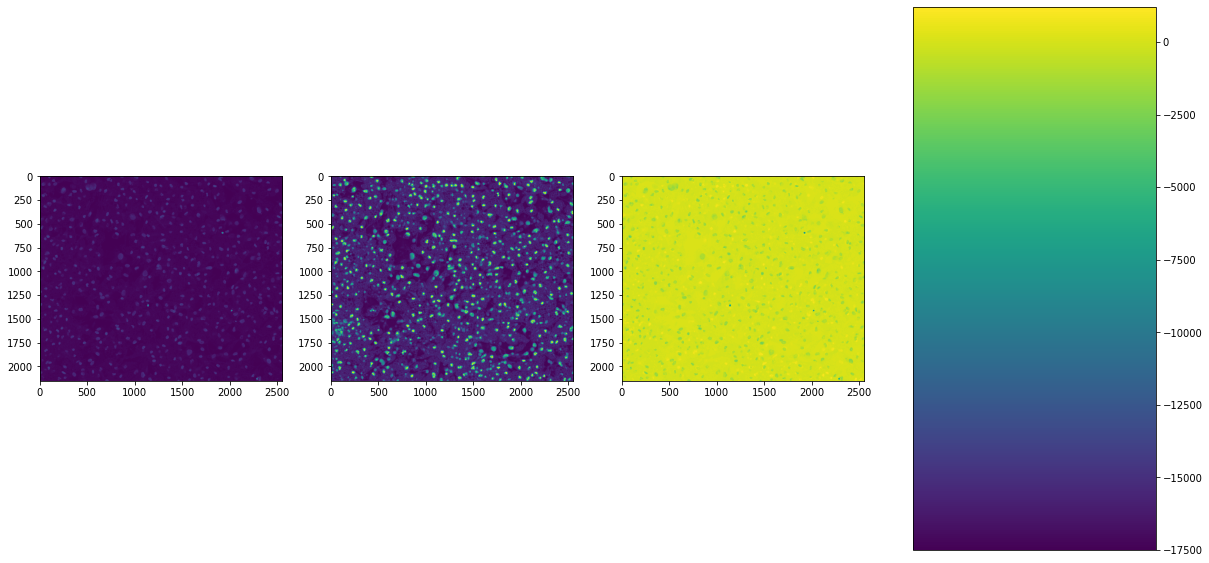

In [25]:
i=1
fig, axs = plt.subplots(1,4, figsize=(20,10))

axs[0].imshow(gt_20x[i][0])
axs[1].imshow(pred_20x[i][0])

error = pred_20x[i][0] - gt_20x[i][0]
im = axs[2].imshow(error)
fig.colorbar(im, axs[3], fraction=0.046)

plt.show()

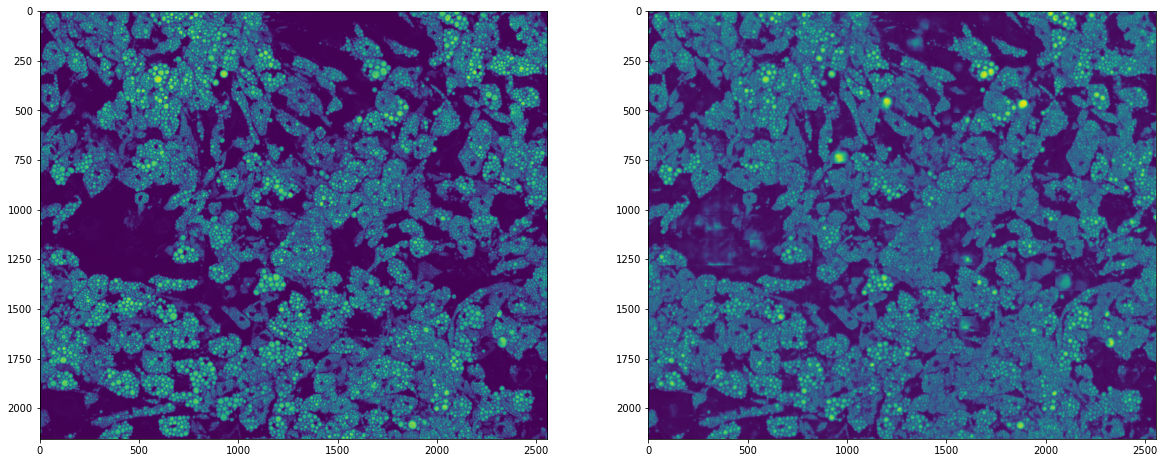

In [76]:
fig, axs = plt.subplots(1,2, figsize=(20,10))

axs[0].imshow(gt_20x[i][1])
axs[1].imshow(pred_20x[i][1])

plt.show()

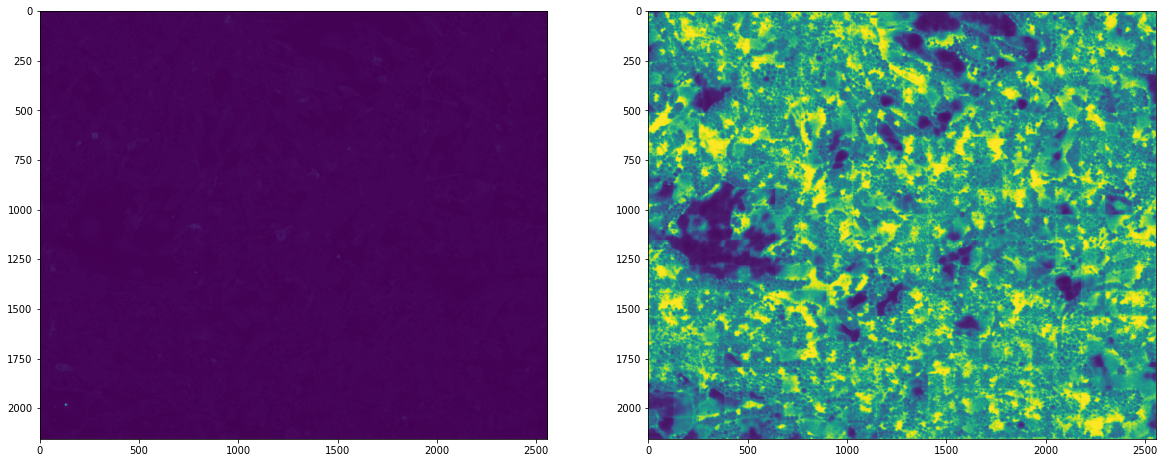

In [77]:
fig, axs = plt.subplots(1,2, figsize=(20,10))

axs[0].imshow(gt_20x[i][2])
axs[1].imshow(pred_20x[i][2])
# axs[2].imshow(pred_20x[i][2] - gt_20x[i][2])

plt.show()

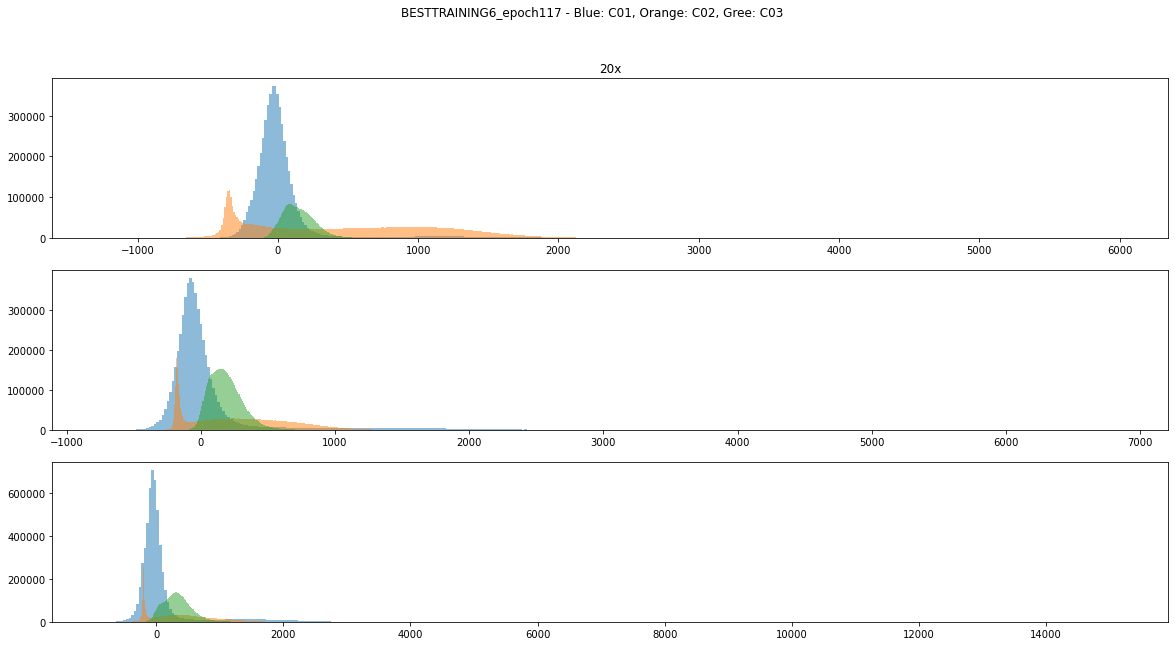

In [23]:
fig, axs = plt.subplots(3, figsize=(20,10))

axs[0].hist((gt_60x[0]-pred_60x[0]).ravel(), bins=400, alpha=0.5)
axs[0].hist((gt_60x[1]-pred_60x[1]).ravel(), bins=400, alpha=0.5)
axs[0].hist((gt_60x[2]-pred_60x[2]).ravel(), bins=400, alpha=0.5)
axs[0].set_title("60x")

axs[1].hist((gt_40x[0]-pred_40x[0]).ravel(), bins=400, alpha=0.5)
axs[1].hist((gt_40x[1]-pred_40x[1]).ravel(), bins=400, alpha=0.5)
axs[1].hist((gt_40x[2]-pred_40x[2]).ravel(), bins=400, alpha=0.5)
axs[0].set_title("40x")

axs[2].hist((gt_20x[0]-pred_20x[0]).ravel(), bins=400, alpha=0.5)
axs[2].hist((gt_20x[1]-pred_20x[1]).ravel(), bins=400, alpha=0.5)
axs[2].hist((gt_20x[2]-pred_20x[2]).ravel(), bins=400, alpha=0.5)
axs[0].set_title("20x")

fig.suptitle('BESTTRAINING6_epoch117 - Blue: C01, Orange: C02, Gree: C03')

plt.show()

In [80]:
0.5*1.42 + 0.1*2.01 + 0.4*0.74, 150*(0.5*0.034 + 0.1*0.023 + 0.4*0.014), 0.1*4

(1.2069999999999999, 3.7350000000000003, 0.4)

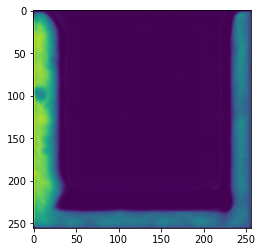

In [43]:
plt.imshow(smt[2][50])

In [78]:
smt[1][~np.isnan(smt[1])].max(), img.max()

(8180.921202932452, 3913)

In [79]:
np.mean(np.power(np.log(smt[1][:1800,:1800])-np.log(img[:1800,:1800]), 2))

0.3275690310623606

In [66]:
from PIL import Image

def save_tiff(img, path):
    
    Image.fromarray(img.astype(np.uint16)).save(path)

save_tiff(img, "output/60x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A01Z01C01.tif")

In [68]:
img

array([[11363,  1548,  6567, ...,  6089,  4632,  1351],
       [ 6310, 10231,  6941, ...,  9726,  3748,  6658],
       [ 3722,  3813,  6924, ...,  5877,  3598,  5538],
       ...,
       [ 5188, 14503,  4915, ...,  7936, 10168,  8501],
       [ 7843,  7699,  2542, ...,  5853, 10998, 10704],
       [10781,   224, 12899, ...,  2942,  9266,  5108]], dtype=uint16)

In [65]:
img = (np.random.uniform(size=(2156, 2556)) * 15000).astype(np.uint16)

In [24]:
x = gt_20x[0]
x[x < 1000] = 0

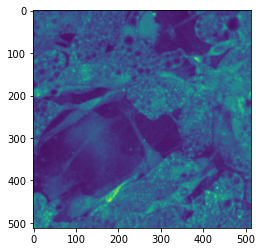

In [15]:
plt.imshow(gt_20x[2][:512,:512])

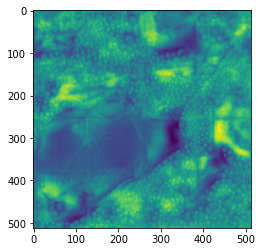

In [16]:
plt.imshow(pred_20x[2][:512,:512])

(array([[2.089e+03, 6.500e+01, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [2.086e+03, 6.800e+01, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [2.083e+03, 7.100e+01, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        ...,
        [2.038e+03, 1.160e+02, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [2.045e+03, 1.090e+02, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [2.042e+03, 1.100e+02, 2.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00]]),
 array([    0. ,  1542.9,  3085.8,  4628.7,  6171.6,  7714.5,  9257.4,
        10800.3, 12343.2, 13886.1, 15429. ]),
 <a list of 2554 BarContainer objects>)

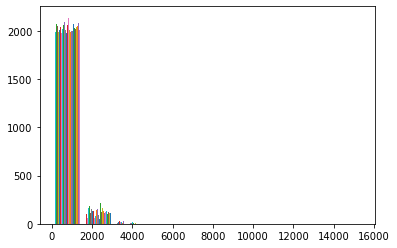

In [27]:
plt.hist(x)

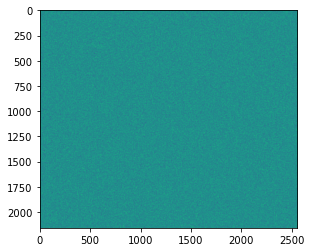

In [67]:
p = 'output/60x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A01Z01C01.tif'
img = plt.imread(p)
img = np.array(img)
plt.imshow(img)

In [1]:
img_tuple = [('/data/40x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z01C04.tif',
             '/data/40x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z02C04.tif',
             '/data/40x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z03C04.tif',
             '/data/40x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z04C04.tif',
             '/data/40x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z05C04.tif',
             '/data/40x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z06C04.tif',
             '/data/40x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z07C04.tif',
             '/data/40x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A01Z01C01.tif',
             '/data/40x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A02Z01C02.tif',
             '/data/40x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A03Z01C03.tif')
]

In [2]:
import matplotlib.pyplot as plt
imgs = [plt.imread(p) for p in img_tuple[0]]

In [3]:
import numpy as np

In [4]:
c01 = imgs[-3]
c02 = imgs[-2]
c03 = imgs[-1]
bf = imgs[:7]

In [59]:
plt.imsave("asd.png", c03/np.max(bf, axis=0))

In [60]:
a = c03/np.mean(bf, axis=0)

In [61]:
print(a.min())
print(a.max())
print(a.mean())

0.05626326963906582
5.536853685368537
0.6016109812420996


In [55]:
len(a[a>5])

0

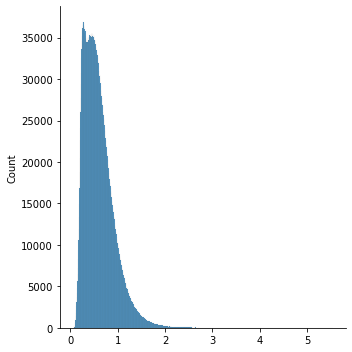

In [62]:
import seaborn as sns
sns.displot(a.ravel())

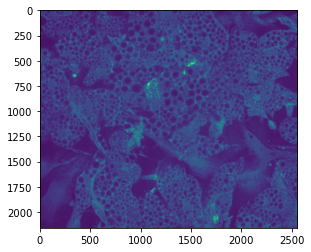

In [27]:
plt.imshow(c03)

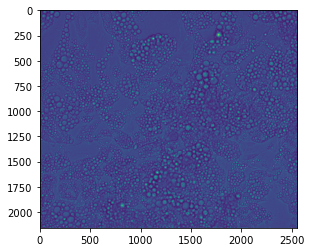

In [12]:
plt.imshow(np.max(bf, axis=0)-np.mena(bf, axis=0))

In [48]:
a = 100
b = 10000

np.log(a) - np.log(b), a-b, a/10 - b/10

(-4.605170185988092, -9900, -990.0)

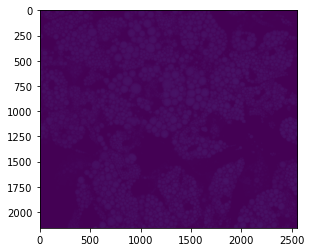

In [62]:
img[0,0] = 15000
plt.imshow(img/65535, vmin=0, vmax=1)

In [50]:
img.max()

3913

In [59]:
img

array([[   0,  774,  749, ...,   18,   23,   22],
       [1075,    0,  857, ...,   16,   23,    8],
       [1060,  963,  904, ...,   30,   23,   20],
       ...,
       [  72,   35,   66, ..., 2200, 2098, 2173],
       [  35,   43,   54, ..., 2212, 2245, 2179],
       [  46,   31,   31, ..., 2090, 2125, 2169]], dtype=uint16)

In [65]:
np.exp(0), np.exp(11)

(1.0, 59874.14171519782)

In [71]:
x = np.arange(-5.0, 5.0, 0.1)
y1 = 1/(1+np.exp(-x))
y2 = (1+np.tanh(x))/2

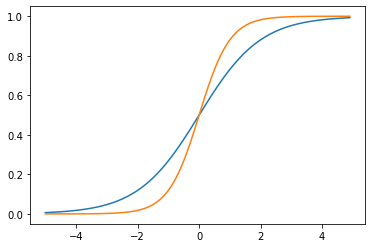

In [74]:
plt.plot(x, y1)
plt.plot(x, y2)

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
gan_train_csv = pd.read_csv("lossinfo/BESTTRAINING6/gan_train_loss_info.csv")
col_names = ["Epoch"]
col_names.extend(list(gan_train_csv.columns)[1:])
gan_train_csv.columns = col_names
gan_train_csv

,Epoch,TotalLoss,v_lossC01,v_lossC02,v_lossC03,m_lossC01,m_lossC02,m_lossC03,adv,valTotalLoss,val_v_lossC01,val_v_lossC02,val_v_lossC03,val_m_lossC01,val_m_lossC02,val_m_lossC03,val_adv
0,0,3.587446,1.720249,4.470972,1.342278,0.037308,0.038018,0.016697,"tensor(0.9379, device='cuda:0', grad_fn=<Binar...",3.812847,2.238979,3.837283,1.169244,0.042035,0.046413,0.018496,"tensor(0.7932, device='cuda:0')"
1,1,3.296764,1.636126,3.427691,1.241897,0.036401,0.038250,0.016944,"tensor(1.2160, device='cuda:0', grad_fn=<Binar...",3.596892,2.267704,3.529636,1.070043,0.039697,0.039084,0.018115,"tensor(0.9936, device='cuda:0')"
2,2,3.173639,1.597276,3.176059,1.187707,0.035771,0.035928,0.016819,"tensor(1.5303, device='cuda:0', grad_fn=<Binar...",3.475782,2.026082,3.601397,1.013971,0.037767,0.041575,0.017910,"tensor(1.1344, device='cuda:0')"
3,3,3.076125,1.574227,3.000838,1.152222,0.034919,0.033568,0.016757,"tensor(1.8311, device='cuda:0', grad_fn=<Binar...",3.318596,1.912501,3.565855,0.963190,0.036295,0.037971,0.016872,"tensor(1.3301, device='cuda:0')"
4,4,3.023060,1.552530,2.907336,1.105259,0.034629,0.033173,0.016756,"tensor(2.0606, device='cuda:0', grad_fn=<Binar...",3.253746,1.904844,3.501063,0.927431,0.035799,0.035765,0.016658,"tensor(1.4822, device='cuda:0')"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,76,2.212221,1.228275,1.656967,0.783295,0.028513,0.017901,0.012635,"tensor(7.6564, device='cuda:0', grad_fn=<Binar...",2.427031,1.433655,2.027600,0.743245,0.032021,0.022115,0.013700,"tensor(1.6898, device='cuda:0')"
77,77,2.199159,1.222673,1.631989,0.778368,0.028443,0.017794,0.012540,"tensor(7.7016, device='cuda:0', grad_fn=<Binar...",2.440606,1.437021,2.021266,0.739060,0.033478,0.022271,0.013251,"tensor(1.3266, device='cuda:0')"
78,78,2.197826,1.220931,1.635384,0.781725,0.028423,0.017528,0.012548,"tensor(7.7161, device='cuda:0', grad_fn=<Binar...",2.452518,1.432575,2.041588,0.733965,0.033858,0.022123,0.013403,"tensor(1.7811, device='cuda:0')"
79,79,2.192784,1.218002,1.626771,0.778353,0.028452,0.017538,0.012434,"tensor(7.8641, device='cuda:0', grad_fn=<Binar...",2.425822,1.437213,2.032596,0.739469,0.031841,0.022822,0.013805,"tensor(0.5275, device='cuda:0')"


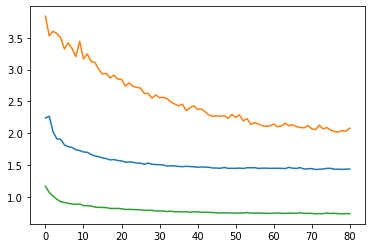

In [27]:
plt.plot(gan_train_csv["Epoch"], gan_train_csv["val_v_lossC01"])
plt.plot(gan_train_csv["Epoch"], gan_train_csv["val_v_lossC02"])
plt.plot(gan_train_csv["Epoch"], gan_train_csv["val_v_lossC03"])